# Reading the SIMBA buoy supplementary data

The SIMBA instruments contain compass data to enable tracking of ice floe rotation. We will need to make an estimate of the accuracy of this information. They also contain additional surface meteorology measurements (pressure, temperature) that we can use if needed. 

To start with, here is the code snippet I used to extract the data from the .tab files.

In [1]:
import sys
sys.path.append('../scripts')
import proplot as pplt
import pandas as pd
import pyproj
import numpy as np
from helpers import *
from sklearn.neighbors import NearestNeighbors

def print(*val):
    display(*val)

%run ../scripts/process_simba.py

The additional data can tell you something about the data quality, and the eventual fate of the sensor. For example, the tilt can show you if the buoy is starting to experience ice breakup, or if the instrument tips over.

## Setup

In [2]:
def toStereo(lat, lon):
    projIn = 'epsg:4326' # WGS 84 Ellipsoid
    projOut = 'epsg:3413' # NSIDC North Polar Stereographic
    transformer = pyproj.Transformer.from_crs(projIn, projOut, always_xy=True)

    return transformer.transform(lon, lat)

In [3]:
full_meta = simba_metadata().merge(buoy_metadata(), left_index=True, right_index=True, how="left")
full_meta.index.names = ['Sensor ID']

def buoyPos(buoy):
    return np.array(simba_data(buoy)[['Latitude', "Longitude"]].head(1))[0]

In [4]:
inits = np.array([buoyPos(buoy) for buoy in full_meta[full_meta["hasCompass"]].index])
lats = inits[:, 0]
lons = inits[:, 1]

x, y = toStereo(lats, lons)
xy = np.dstack([x,y])[0]

nn = NearestNeighbors(n_neighbors=2).fit(xy)
dist, clusters = nn.kneighbors(xy)

print(np.array(simba_metadata().index)[clusters])
#print(clusters)
print(dist[:, 1])

#fig, ax = pplt.subplots(figsize=(10,10))
#ax.scatter(x[clusters[0]], y[clusters[0]])

array([['2019T47', '2019T65'],
       ['2019T56', '2019T70'],
       ['2019T58', '2019T65'],
       ['2019T62', '2019T64'],
       ['2019T63', '2019T66'],
       ['2019T64', '2019T62'],
       ['2019T65', '2019T58'],
       ['2019T66', '2019T63'],
       ['2019T67', '2019T66'],
       ['2019T68', '2019T62'],
       ['2019T69', '2019T64'],
       ['2019T70', '2019T56'],
       ['2019T72', '2020T73'],
       ['2020T73', '2019T72'],
       ['2020T74', '2020T77'],
       ['2020T75', '2019T72'],
       ['2020T76', '2020T73'],
       ['2020T77', '2020T76'],
       ['2020T79', '2020T85'],
       ['2020T61', '2020T79'],
       ['2020T85', '2020T79']], dtype=object)

array([ 31229.03594476,  10773.0225445 ,    423.30456704,    690.47005257,
        13298.60252057,    690.47005257,    423.30456704,  13298.60252057,
        17551.02253546,   4962.02814454,  17072.20812139,  10773.0225445 ,
         6812.52174454,   6812.52174454,  43529.55377426,   7341.26908673,
        11209.4242486 ,  27763.51770201, 112824.44552996, 162861.51597018,
       112824.44552996])

## Buoy Velocities

In [5]:
print(full_meta.columns)
print()
for buoy in full_meta[full_meta["hasCompass"] == True].index:
    print(buoy, buoy_metadata().loc[buoy, "Calculated Frequency"])

Index(['Event (Deployment device operation ID)',
       'Other event (Recovery device operation ID ...)', 'ID (Original name)',
       'ID (IMEI)', 'Date/Time (Deployment Date)',
       'Latitude (Deloyment location)', 'Longitude (Deloyment location)',
       'Site (Deployment site)', 'Comment', 'hasCompass', 'Deployment Leg',
       'DN Station ID', 'IMEI', 'Deployment Date', 'Deployment Datetime',
       'First Data Datetime', 'Last Data Datetime', 'Active',
       'Sampling Frequency (hh:mm)', 'Re-deployed As', 'Formerly Deployed As',
       'Buoy Type', 'Manufacturer', 'Model', 'PI', 'Data Authors',
       'Calculated Frequency', 'Interp'],
      dtype='object')

'2019T56'

'120min'

'2019T58'

'120min'

'2019T62'

'30min'

'2019T63'

'30min'

'2019T64'

'30min'

'2019T65'

'30min'

'2019T66'

'30min'

'2019T67'

'30min'

'2019T68'

'120min'

'2019T69'

'60min'

'2019T70'

'120min'

'2019T72'

'120min'

'2020T73'

'30min'

'2020T74'

'30min'

'2020T75'

'30min'

'2020T76'

'30min'

'2020T77'

'30min'

'2020T79'

'30min'

'2020T61'

'120min'

'2020T85'

'120min'

'2020T60'

'720min'

In [143]:
def rotational_velocity(data):
    shifts = data - data.shift()
    shifts[shifts > 180] = 360 - shifts[shifts > 180]
    shifts[shifts < -180] = 360 + shifts[shifts < -180]
    shifts.plot()
    dt = data.index.diff()/pd.Timedelta(hours=1)
    return shifts.div(np.array(dt), axis=0)

Date/Time
2019-11-02 11:00:00    275.0
2019-11-03 11:00:00    273.0
2019-11-04 11:00:00    274.0
2019-11-05 11:00:00    272.0
2019-11-06 11:00:00    271.0
                       ...  
2020-06-14 11:00:00     17.0
2020-06-15 11:00:00     23.0
2020-06-16 11:00:00     13.0
2020-06-17 11:00:00     28.0
2020-06-20 11:00:00     27.0
Name: a, Length: 229, dtype: float64

Date/Time
2019-10-07 11:00:00    107.0
2019-10-08 11:00:00    106.0
2019-10-09 11:00:00    107.0
2019-10-10 11:00:00    106.0
2019-10-11 11:00:00    106.0
                       ...  
2020-07-29 11:00:00    100.0
2020-07-30 11:00:00    101.0
2020-07-31 11:00:00    110.0
2020-08-01 11:00:00    101.0
2020-08-02 11:00:00    105.0
Freq: D, Name: b, Length: 301, dtype: float64

,a,b
Date/Time,,
2019-11-03 11:00:00,-0.083333,0.041667
2019-11-06 11:00:00,-0.041667,0.041667
2019-11-07 11:00:00,0.083333,0.041667
2019-11-10 11:00:00,-0.166667,-0.041667
2019-11-11 11:00:00,0.375000,0.041667
...,...,...
2020-06-12 11:00:00,0.083333,-0.083333
2020-06-15 11:00:00,0.250000,0.083333
2020-06-16 11:00:00,-0.416667,-0.083333


,a,b
a,1.000000,0.096302
b,0.096302,1.000000


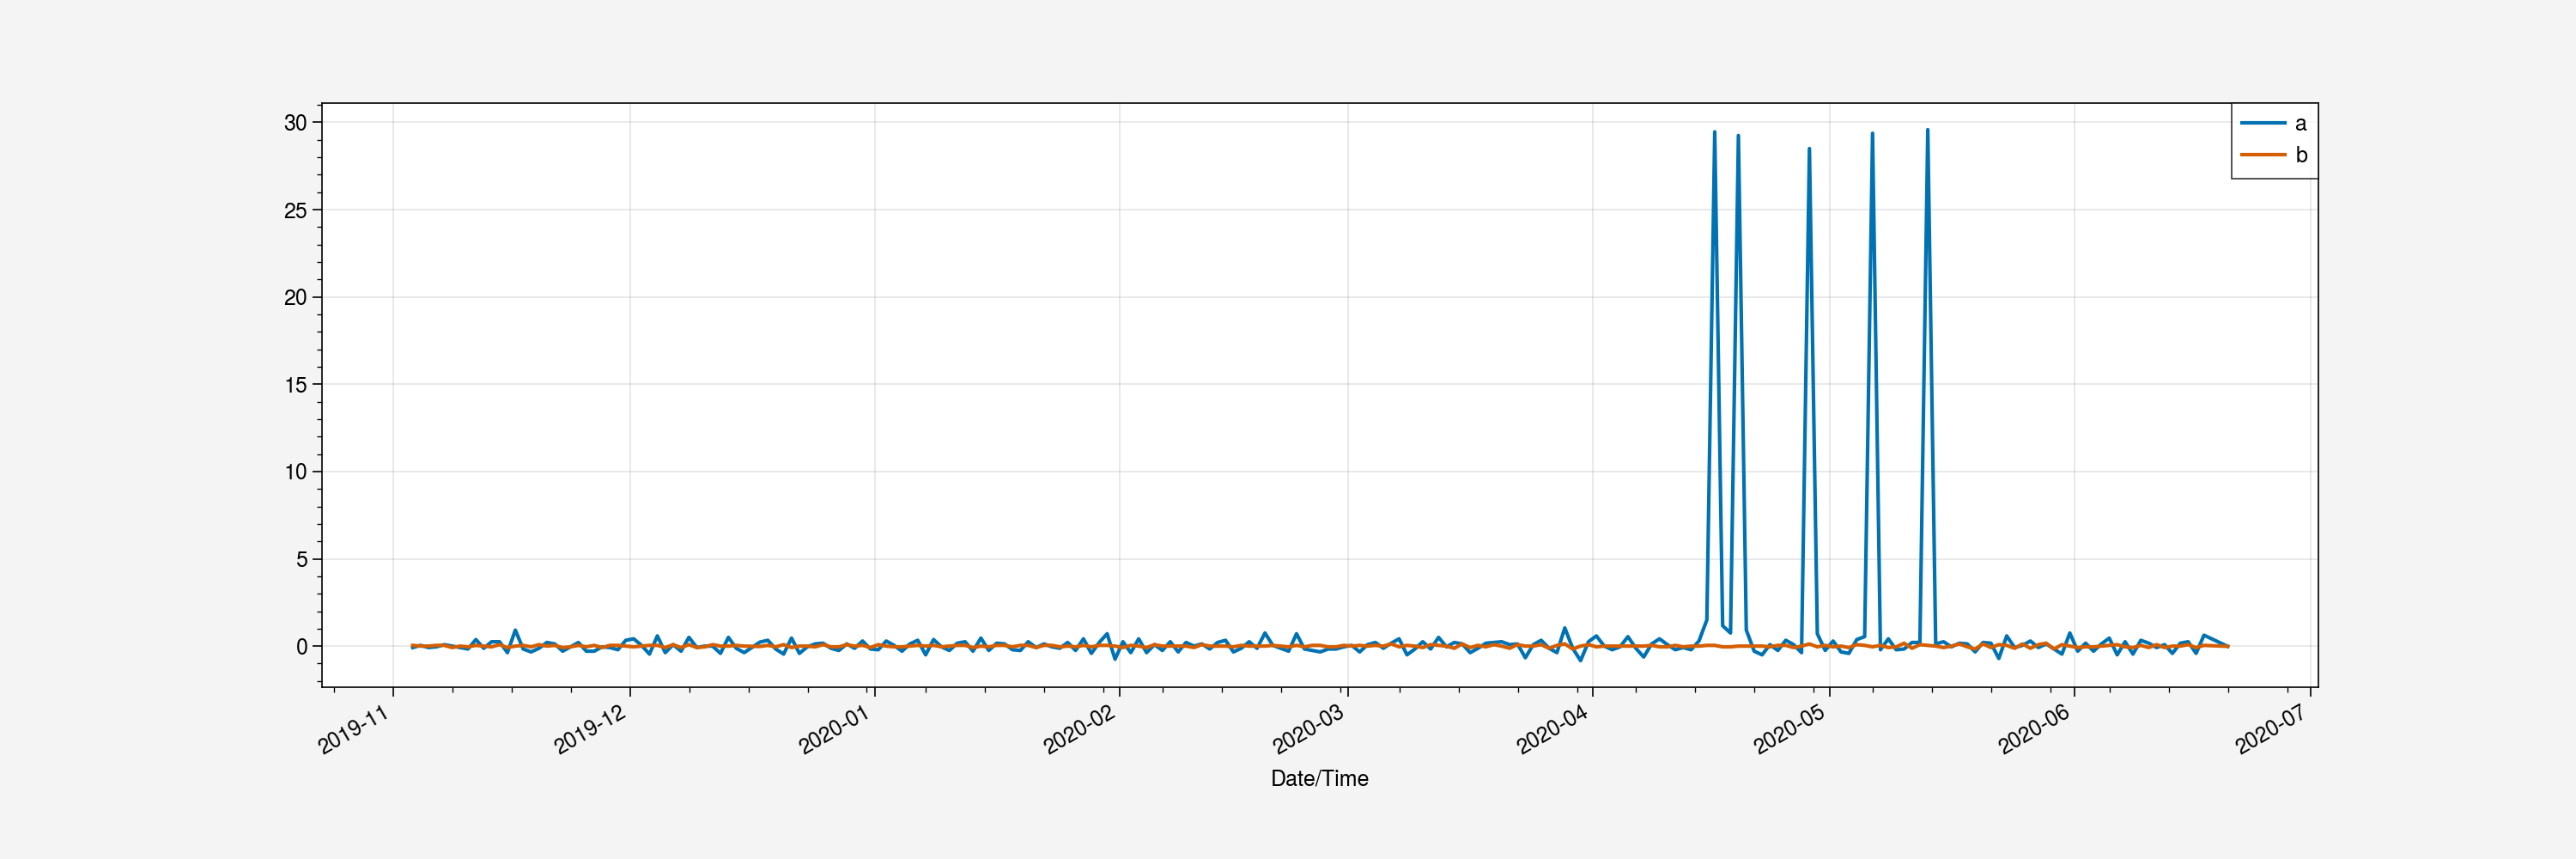

In [132]:
a = (simba_data("2019T56").set_index("Date/Time")["Compass bearing [deg]"]).rename("a")
b = (simba_data("2019T65").set_index("Date/Time")["Compass bearing [deg]"]).rename("b")
a.index = pd.to_datetime(a.index)
b.index = pd.to_datetime(b.index)

a = a.resample("1d", offset="11h").asfreq().dropna()
b = b.resample("1d", offset="11h").asfreq().dropna()

print(a,b)

combined = pd.concat([a, b], axis=1).dropna()

velocities = rotational_velocity(combined)
velocities.plot(figsize=(15,5))

thresh = 0.5
both_large = (abs(velocities) > 0).all(axis=1)

combined = velocities[both_large]
print(combined)

# different_sign = np.logical_xor(np.array(combined["a"] > 0), np.array(combined["b"] > 0))
# print(len(different_sign) - different_sign.sum())
print(combined.corr())

# data["Tilt [deg]"].plot(xticks=[], figsize=(10,5))
# data["Compass bearing [deg]"].plot(xticks=[], figsize=(10,5))

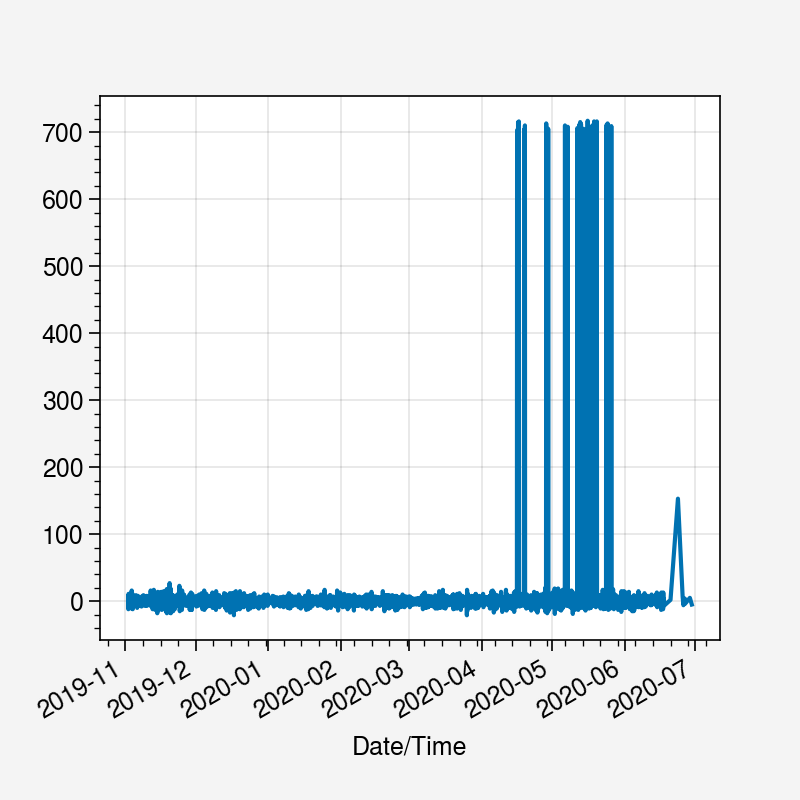

In [142]:
a = (simba_data("2019T56").set_index("Date/Time")["Compass bearing [deg]"])
# a.plot(marker='.')
a.index = pd.to_datetime(a.index)
a = a.resample("1h").asfreq().dropna()
# a = a["2020-05-05":"2020-05-09"]
velocities = rotational_velocity(a)
# velocities.plot(figsize=(15,5))

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


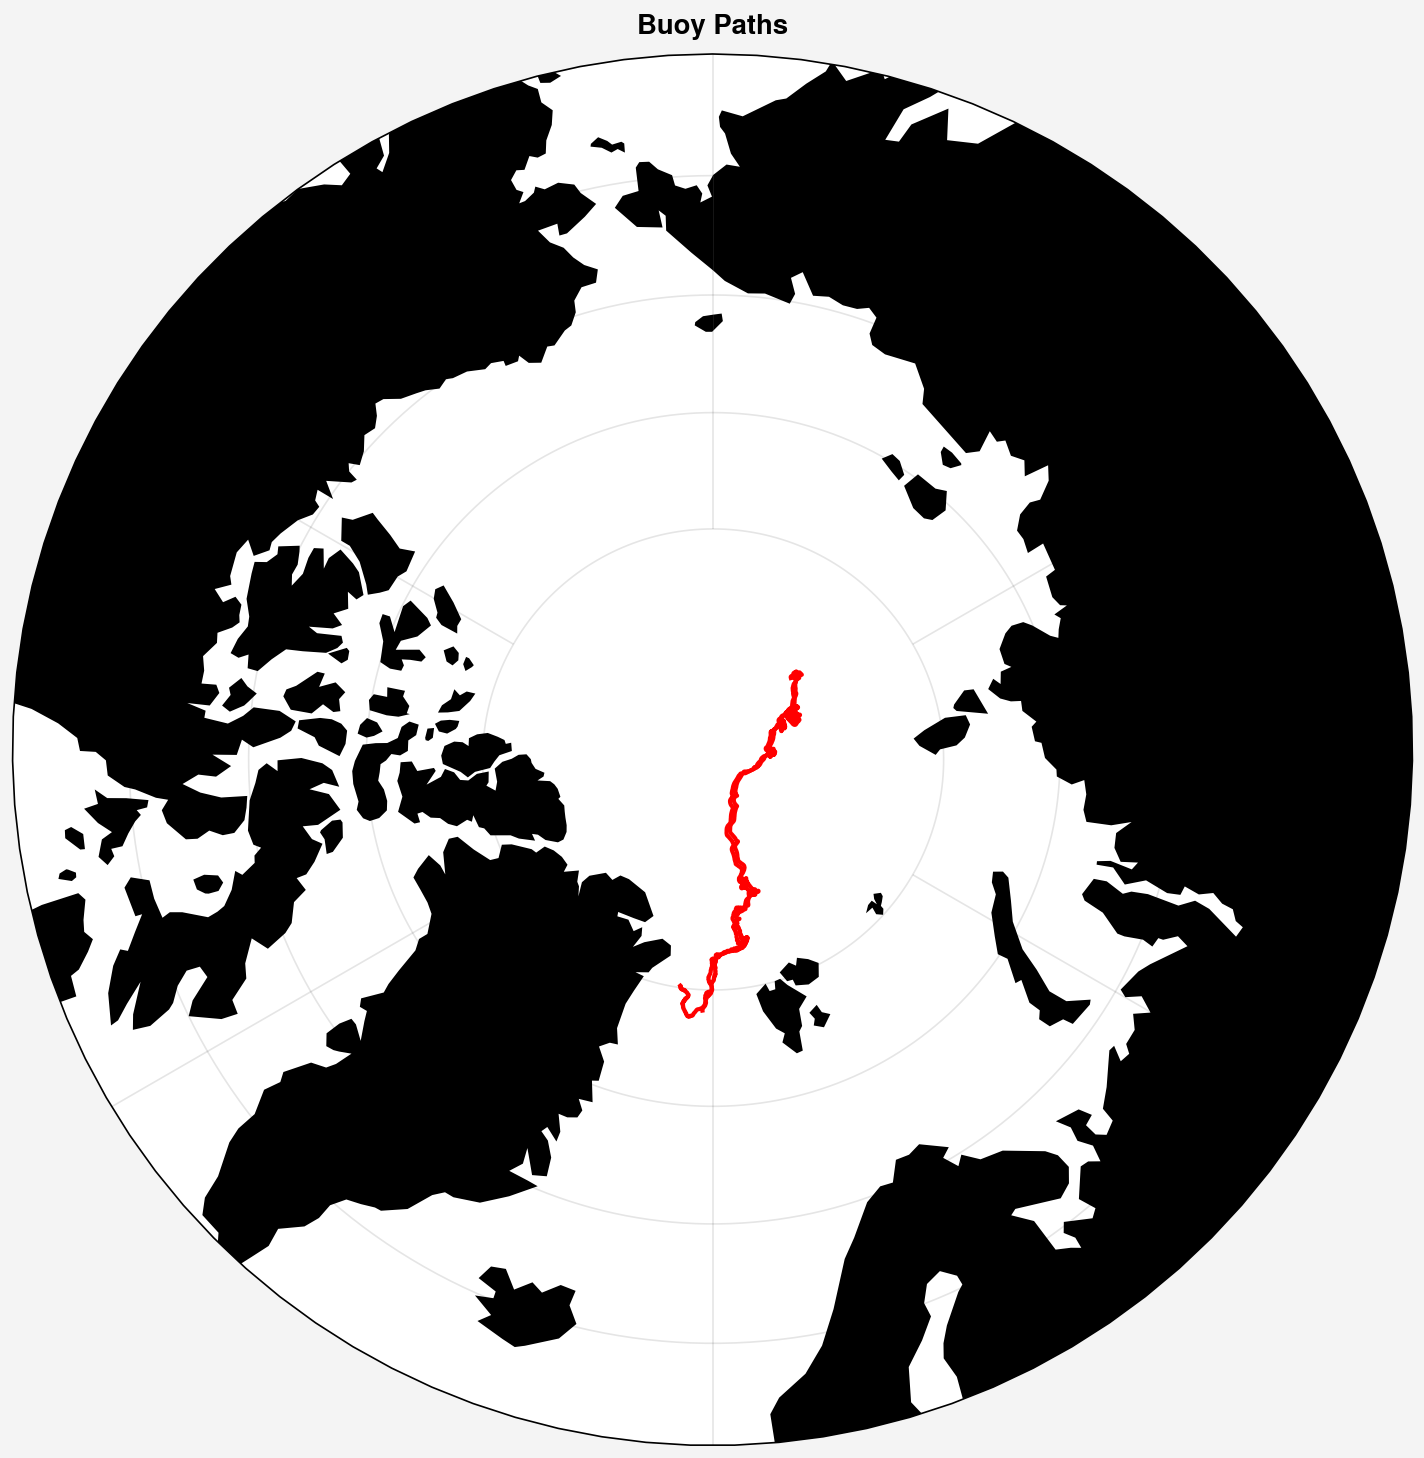

In [20]:
plot_path(["2019T58", "2019T65"])

a =toStereo(simba_data("2019T58")["Latitude"], simba_data("2019T58")["Longitude"])
b = toStereo(simba_data("2019T65")["Latitude"], simba_data("2019T65")["Longitude"])

#simba_data("2019T58")["Longitude"].corr(simba_data("2019T65")["Longitude"])

## Does distance between buoys change over time?

datetime
2020-04-04 15:30:00    14048.040028
2020-04-04 16:00:00    14045.700033
2020-04-04 16:30:00    14046.788460
2020-04-04 17:00:00    14048.770247
2020-04-04 17:30:00    14049.282455
                           ...     
2020-07-21 09:30:00    53135.624096
2020-07-21 10:00:00    53047.439173
2020-07-21 10:30:00    52963.291491
2020-07-21 11:00:00    52869.804571
2020-07-21 11:30:00    52779.511784
Name: dist, Length: 5177, dtype: float64

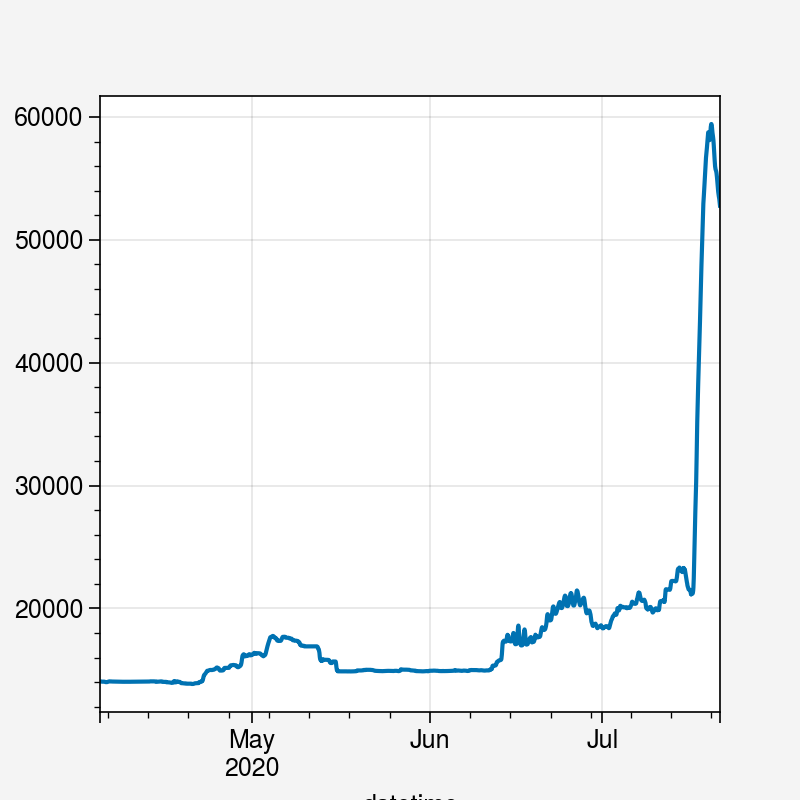

In [8]:
a = buoy_data(full_meta.index[16]).set_index("datetime")[["x_stere", "y_stere"]]
b = buoy_data(full_meta.index[14]).set_index("datetime")[["x_stere", "y_stere"]]

merged = a.merge(b, left_index=True, right_index=True, suffixes=["1","2"])
merged["dist"] = np.sqrt((merged["x_stere1"] - merged["x_stere2"])**2 + (merged["y_stere1"] - merged["y_stere2"])**2)

merged['dist'].plot()
print(merged['dist'])